# Model-2: Adding Batch Normalization for Stability

BatchNorm improves training stability and speeds up convergence

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets

In [2]:
try:
    from torchinfo import summary
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchinfo"])
    from torchinfo import summary

In [3]:
try:
    import torchmetrics
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    import torchmetrics

In [4]:
import os
repo_url = "https://raw.githubusercontent.com/vardanskamra/Deep-Multimedia-Steganography/main/utils"
files = [
    "__init__.py",
    "test.py",
    "train.py",
    "metrics.py",
    "transforms.py",
    "visualizations.py",
    "inference.py"
]
os.makedirs("utils", exist_ok=True)

for file in files:
    file_url = f"{repo_url}/{file}"
    os.system(f"curl -s {file_url} -o utils/{file}")

print("Downloaded all utils files successfully!")

Downloaded all utils files successfully!


In [5]:
import sys
sys.path.append("./utils") 

In [6]:
import utils

from utils.transforms import train_test_transform
from utils.metrics import loss_function
from utils.train import train
from utils.test import test

from utils.visualizations import plot_metrics
from utils.visualizations import visualize_images

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=train_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 169M/169M [00:04<00:00, 35.2MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Train DataLoader Length: {len(train_loader)}")
print(f"Test DataLoader Length: {len(test_loader)}")

sample, label = next(iter(train_loader))
print(f"Sample Shape: {sample.shape}")
print(f"Label Shape: {label.shape}")

Train Dataset Length: 50000
Test Dataset Length: 10000
Train DataLoader Length: 1563
Test DataLoader Length: 313
Sample Shape: torch.Size([32, 3, 128, 128])
Label Shape: torch.Size([32])


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [11]:
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, secret):
        return self.layers(secret)

In [12]:
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(6, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, cover, secret_prepared):
        x = torch.cat([cover, secret_prepared], dim=1)
        return self.layers(x)

In [13]:
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )
    
    def forward(self, stego):
        return self.layers(stego)

In [22]:
print(f"Device: {device}")
prep_net = nn.DataParallel(PrepNetwork()).to(device)
hide_net = nn.DataParallel(HidingNetwork()).to(device)
reveal_net = nn.DataParallel(RevealNetwork()).to(device)

Device: cuda


In [23]:
print("PrepNetwork Summary:")
print(summary(prep_net, input_size=(32, 3, 128, 128)))

cover = torch.randn(32, 3, 128, 128)
secret_prepared = torch.randn(32, 3, 128, 128)

print("\nHidingNetwork Summary:")
print(summary(hide_net, input_data=[cover, secret_prepared])) # 6 channels (cover + secret_prepared)

print("\nRevealNetwork Summary:")
print(summary(reveal_net, input_size=(32, 3, 128, 128)))

PrepNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [32, 3, 128, 128]         --
├─PrepNetwork: 1-1                       [16, 3, 128, 128]         302,979
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Sequential: 2-1                   [16, 3, 128, 128]         302,979
│    └─Sequential: 2-4                   --                        (recursive)
│    │    └─ConvBlock: 3-1               [16, 128, 128, 128]       3,840
│    │    └─ConvBlock: 3-7               --                        (recursive)
├─PrepNetwork: 1-3                       [16, 3, 128, 128]         --
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Sequential: 2-3                   [16, 3, 128, 128]         --
│    └─Sequential: 2-4                   --                        (recursive)
│    │    └─ConvBlock: 3-3               [16, 128, 128, 128]       --
│    │

In [24]:
optimizer = torch.optim.Adam(list(prep_net.parameters()) +
                       list(hide_net.parameters()) +
                       list(reveal_net.parameters()), lr=0.001)

In [25]:
train_metrics = train(dataloader=train_loader,
                prep_net=prep_net,
                hide_net=hide_net,
                reveal_net=reveal_net,
                optimizer=optimizer,
                loss_fn=loss_function,
                beta=0.75,
                epochs=25,
                device=device)

Epoch [1/25], Loss: 0.0311, PSNR: 19.1018, SSIM: 0.7913, NC: 0.8849, Pixel Loss (Cover-Stego): 0.0889, Pixel Loss (Secret-Revealed): 0.1025
Epoch [2/25], Loss: 0.0187, PSNR: 20.9527, SSIM: 0.8467, NC: 0.9223, Pixel Loss (Cover-Stego): 0.0704, Pixel Loss (Secret-Revealed): 0.0858
Epoch [3/25], Loss: 0.0139, PSNR: 21.9258, SSIM: 0.8711, NC: 0.9419, Pixel Loss (Cover-Stego): 0.0628, Pixel Loss (Secret-Revealed): 0.0738
Epoch [4/25], Loss: 0.0123, PSNR: 22.3549, SSIM: 0.8797, NC: 0.9487, Pixel Loss (Cover-Stego): 0.0594, Pixel Loss (Secret-Revealed): 0.0694
Epoch [5/25], Loss: 0.0115, PSNR: 22.6320, SSIM: 0.8811, NC: 0.9520, Pixel Loss (Cover-Stego): 0.0576, Pixel Loss (Secret-Revealed): 0.0664
Epoch [6/25], Loss: 0.0105, PSNR: 22.8163, SSIM: 0.8860, NC: 0.9584, Pixel Loss (Cover-Stego): 0.0566, Pixel Loss (Secret-Revealed): 0.0627
Epoch [7/25], Loss: 0.0100, PSNR: 22.9971, SSIM: 0.8854, NC: 0.9601, Pixel Loss (Cover-Stego): 0.0553, Pixel Loss (Secret-Revealed): 0.0607
Epoch [8/25], Loss: 

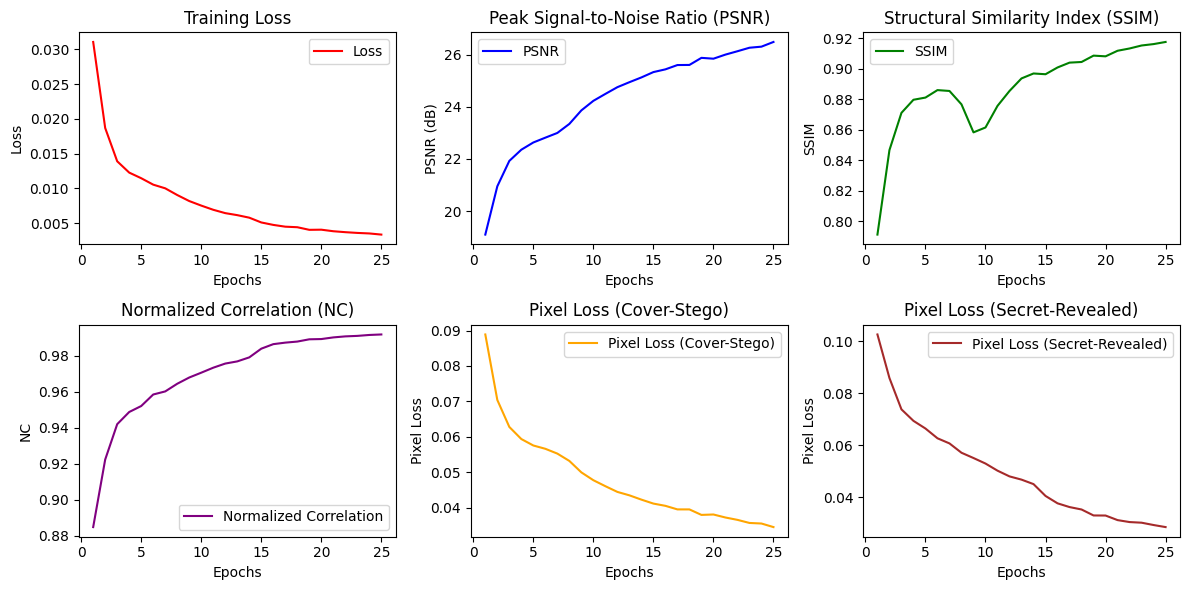


Final Evaluation Metrics:
Final Loss: 0.0034
Final PSNR: 26.4839 dB
Final SSIM: 0.9175
Final Normalized Correlation (NC): 0.9917
Final Pixel Loss (Cover-Stego): 0.0345
Final Pixel Loss (Secret-Revealed): 0.0286



In [26]:
plot_metrics(train_metrics)

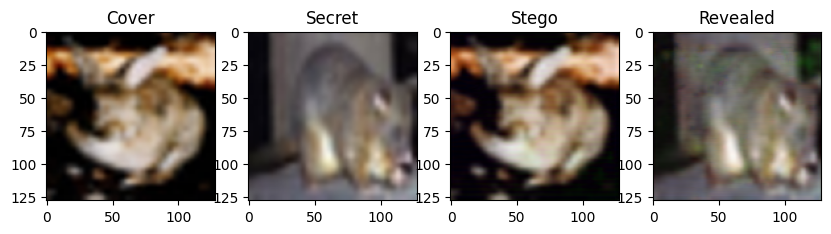

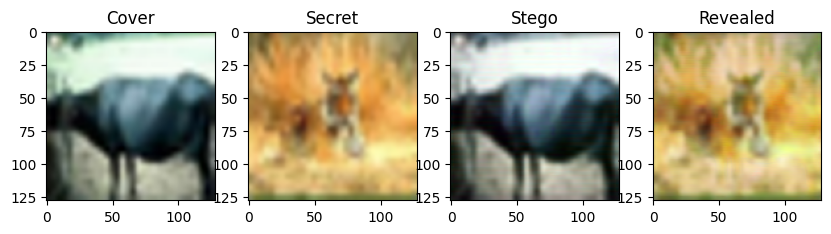

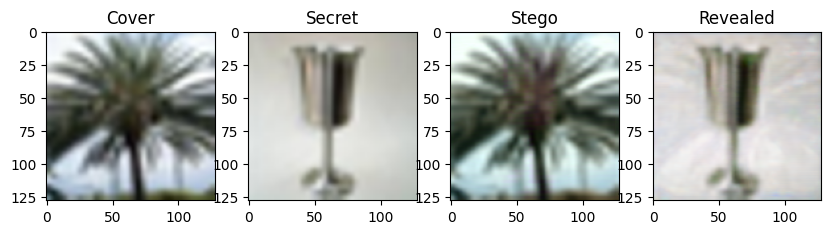

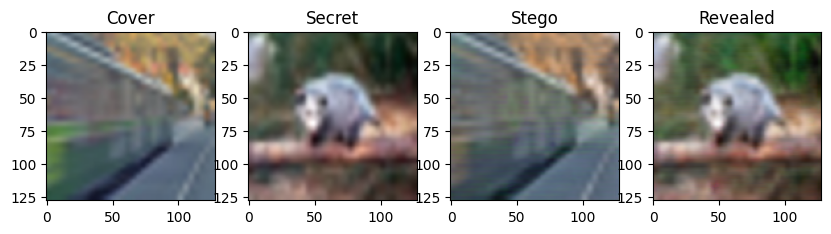

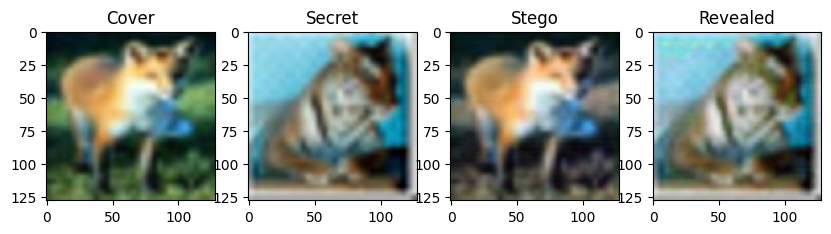

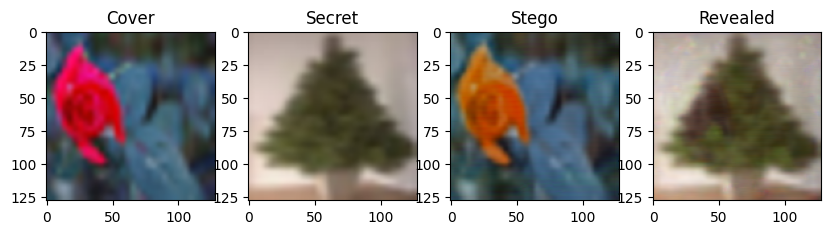

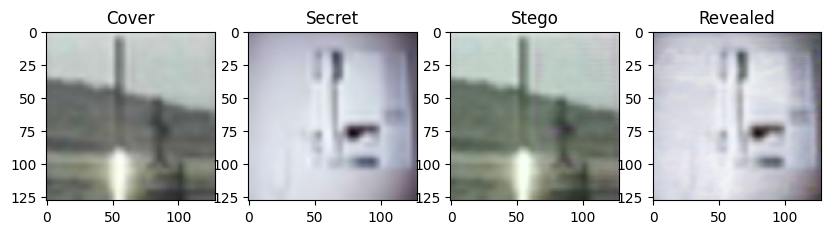

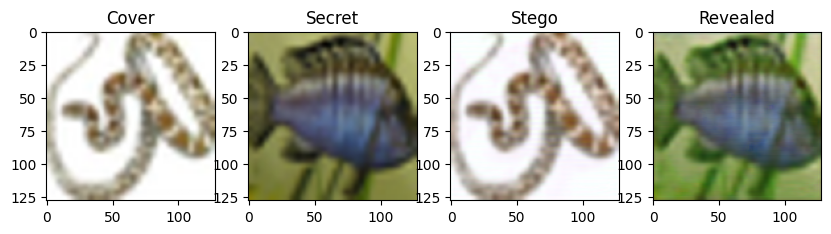

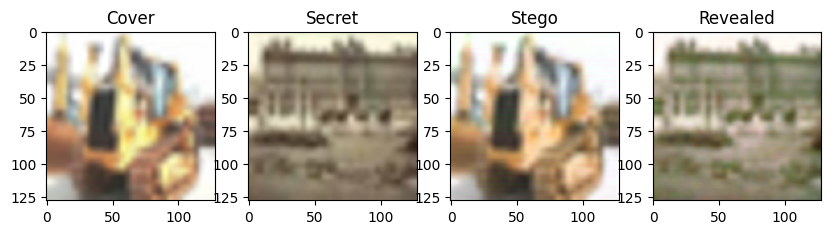

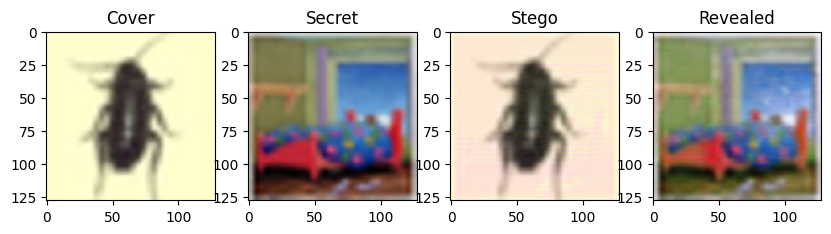

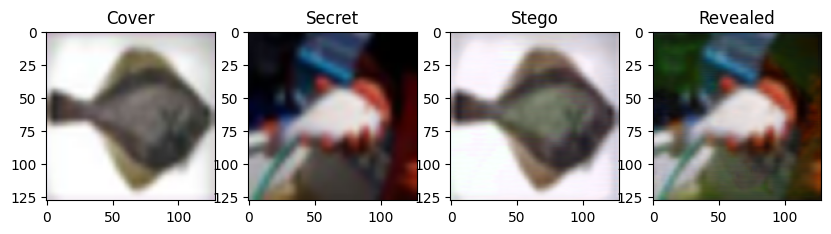

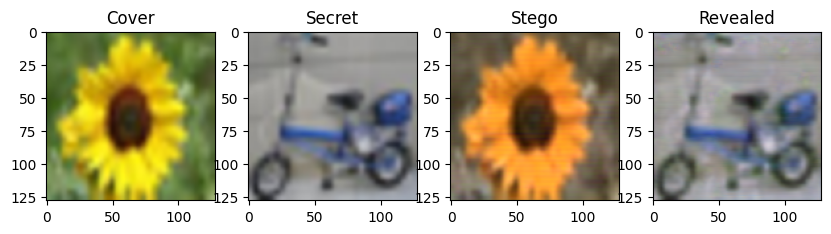

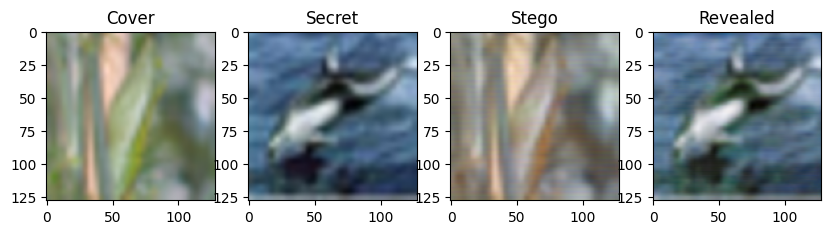

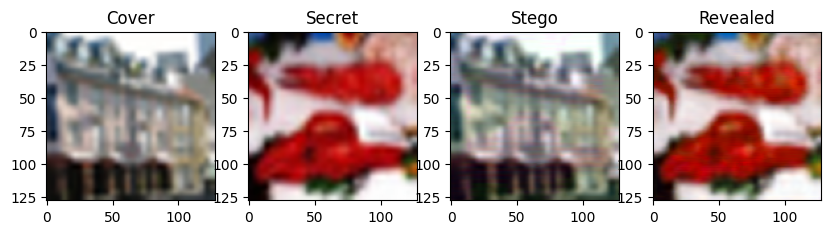

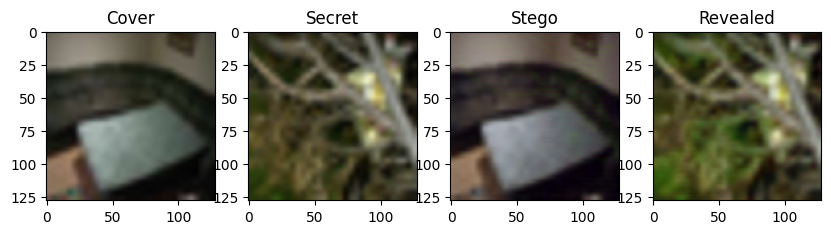


Test Results: Loss: 0.0032, PSNR: 27.7604, SSIM: 0.9271, NC: 0.9895, Pixel Loss (Cover-Stego): 0.0275, Pixel Loss (Secret-Revealed): 0.0318



In [27]:
test_metrics = test(prep_net=prep_net,
               hide_net=hide_net,
               reveal_net=reveal_net,
               dataloader=test_loader,
               loss_fn = loss_function,
               beta = 0.75,
               visualize = True,
               device=device)

In [28]:
checkpoint = {
    'epoch': 25, # New training stars from epoch 25, we've done 0-24
    'prep_net_state_dict': prep_net.module.state_dict(),
    'hide_net_state_dict': hide_net.module.state_dict(),
    'reveal_net_state_dict': reveal_net.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, "model_checkpoint.pth")

In [29]:
torch.save(prep_net.state_dict(), "/kaggle/working/prep_net.pth")
torch.save(hide_net.state_dict(), "/kaggle/working/hide_net.pth")
torch.save(reveal_net.state_dict(), "/kaggle/working/reveal_net.pth")